In [120]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [121]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

In [122]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    output_colors = [color_map[chem] for chem in output_labels]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    unique_labels = sorted(list(set(output_labels)))
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_labels,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [123]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [124]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [125]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    # generate a list of random indices of len = noise_pct% of target location and change values at each index to 0
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = 0
    input_list.append(input_spectra)

    condition_encodings = spectra[list(columns)][-12:].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        labels.append(list(spectra[col][915:-12]))
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    # shifting to make all data positive
    min_value = 1
    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    input_data += min_value
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    all_true_vals += min_value
    # log transforming data to reduce impact of different scales 
    input_normed = torch.log(input_data)
    trues_normed = torch.log(all_true_vals)
    input_data = TensorDataset(input_normed, trues_normed, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [126]:
def create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if test_chem in col]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  for col in all_test_chem_columns:
    instrument_encoding = list(spectra[col][-12:])
    # filter out the test instrument type
    if instrument_encoding.index(1) == instrument_idx:
      test_cols.append(col)

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)

  return train_input, test_input

In [127]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.denoiser = nn.Sequential(
      nn.Linear(1439,1439),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1439,1439),
    )

    self.optimizer = torch.optim.AdamW(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [128]:
def get_loss(model, true_vals, output_0, output_1, output_2, start_idx, end_idx):
    true_data = true_vals[:,start_idx:end_idx]
    output_data_0 = output_0[:, start_idx:end_idx]
    output_data_1 = output_1[:, start_idx:end_idx]
    output_data_2 = output_2[:, start_idx:end_idx]

    m_0_loss = model.criterion(output_data_0, true_data)
    m_1_loss = model.criterion(output_data_1, true_data)
    m_2_loss = model.criterion(output_data_2, true_data)
    loss = m_0_loss + m_1_loss + m_2_loss 
    return loss

In [129]:
def train_denoiser(model, data, test_data, sorted_chemical_names, epochs, train_loss_log = [], test_loss_log = []):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        with torch.no_grad(): 
            test_loss = 0
            for batch, true_vals, labels in test_data:
                output_0= model(batch)
                output_1= model(output_0)
                output_2= model(output_1)
                m_0_loss = model.criterion(output_0, true_vals)
                m_1_loss = model.criterion(output_1, true_vals)
                m_2_loss = model.criterion(output_2, true_vals)

                loss = m_0_loss + m_1_loss + m_2_loss
                test_loss += loss 

            average_test_loss = test_loss/len(test_data)
            
        # accumulate epoch output and loss
        epoch_training_loss = 0
        epoch_spec_loss = 0
        epoch_cond_loss = 0
        epoch_emb_loss = 0
        for batch, true_vals, labels in data:
            output_0= model(batch)
            output_1= model(output_0)
            output_2= model(output_1)
            
            spec_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=0, end_idx=915)
            epoch_spec_loss+=spec_loss
            cond_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=915, end_idx=927)
            epoch_cond_loss+=cond_loss
            emb_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=927, end_idx=1439)
            epoch_emb_loss+=emb_loss

            m_0_loss = model.criterion(output_0, true_vals)
            m_1_loss = model.criterion(output_1, true_vals)
            m_2_loss = model.criterion(output_2, true_vals)
            
            loss = m_0_loss + m_1_loss + m_2_loss
            epoch_training_loss += loss

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
                    # undo log transformation
                    denoised_vector = torch.exp(denoised_vector) - 1
                    model_output.append(denoised_vector)
                    true_val = torch.exp(true_val) - 1 
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)
        

        average_loss = epoch_training_loss/len(data)
        avg_spec_loss = epoch_spec_loss/len(data)
        avg_cond_loss = epoch_cond_loss/len(data)
        avg_emb_loss = epoch_emb_loss/len(data)

        train_loss_log.append(average_loss.detach().numpy())
        test_loss_log.append(average_test_loss.detach().numpy())
        
        if (epoch+1) % 10 == 0:
            print('Epoch[{}/{}], train loss: {}, test loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), round(float(average_test_loss.detach().numpy()), 6)))
            print(f'Spec: {round(float(avg_spec_loss.detach().numpy()), 6)}, Cond: {round(float(avg_cond_loss.detach().numpy()), 6)}, Emb: {round(float(avg_emb_loss.detach().numpy()), 6)}')
            print('--------------------------------------------------------')

    return model_output, output_labels, true_vals_output, train_loss_log, test_loss_log

In [130]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [133]:
loss_type = 'spectra'
train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=loss_type, noise_pct=.8)

In [134]:
denoiser = Denoiser()
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=200, train_loss_log = [], test_loss_log = [])

Epoch[10/200], train loss: 0.185142, test loss: 0.129855
Spec: 0.252151, Cond: 0.070775, Emb: 0.068071
--------------------------------------------------------
Epoch[20/200], train loss: 0.136243, test loss: 0.095234
Spec: 0.195251, Cond: 0.064214, Emb: 0.032476
--------------------------------------------------------
Epoch[30/200], train loss: 0.111942, test loss: 0.085497
Spec: 0.162997, Cond: 0.057123, Emb: 0.021986
--------------------------------------------------------
Epoch[40/200], train loss: 0.095676, test loss: 0.077954
Spec: 0.140054, Cond: 0.05137, Emb: 0.017405
--------------------------------------------------------
Epoch[50/200], train loss: 0.083377, test loss: 0.074576
Spec: 0.12275, Cond: 0.047412, Emb: 0.013854
--------------------------------------------------------
Epoch[60/200], train loss: 0.075058, test loss: 0.072467
Spec: 0.110766, Cond: 0.044294, Emb: 0.011965
--------------------------------------------------------
Epoch[70/200], train loss: 0.069675, test 

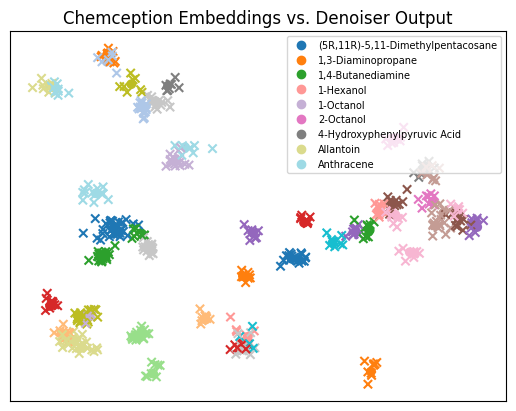

In [135]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

In [149]:
output_labels[0]

'Glycine'

Weighted cosine similarity is:  0.97


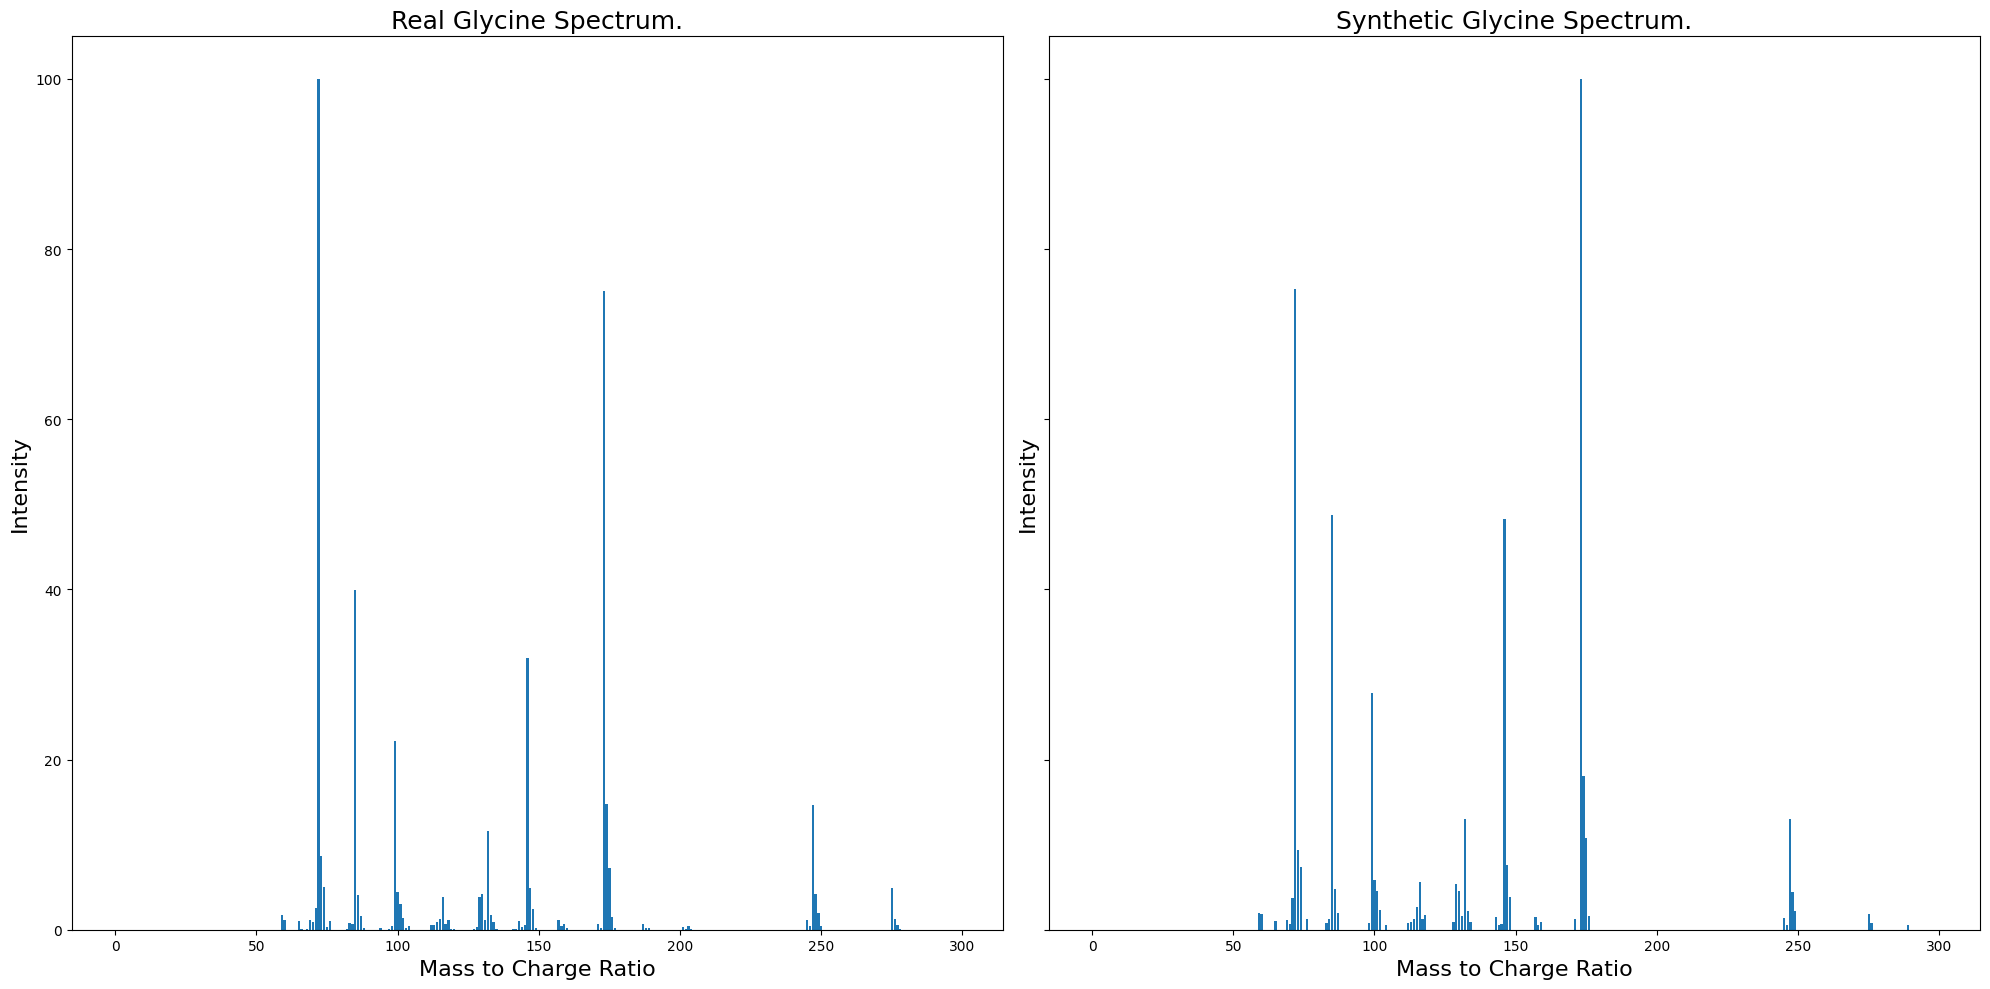

Weighted cosine similarity is:  0.99


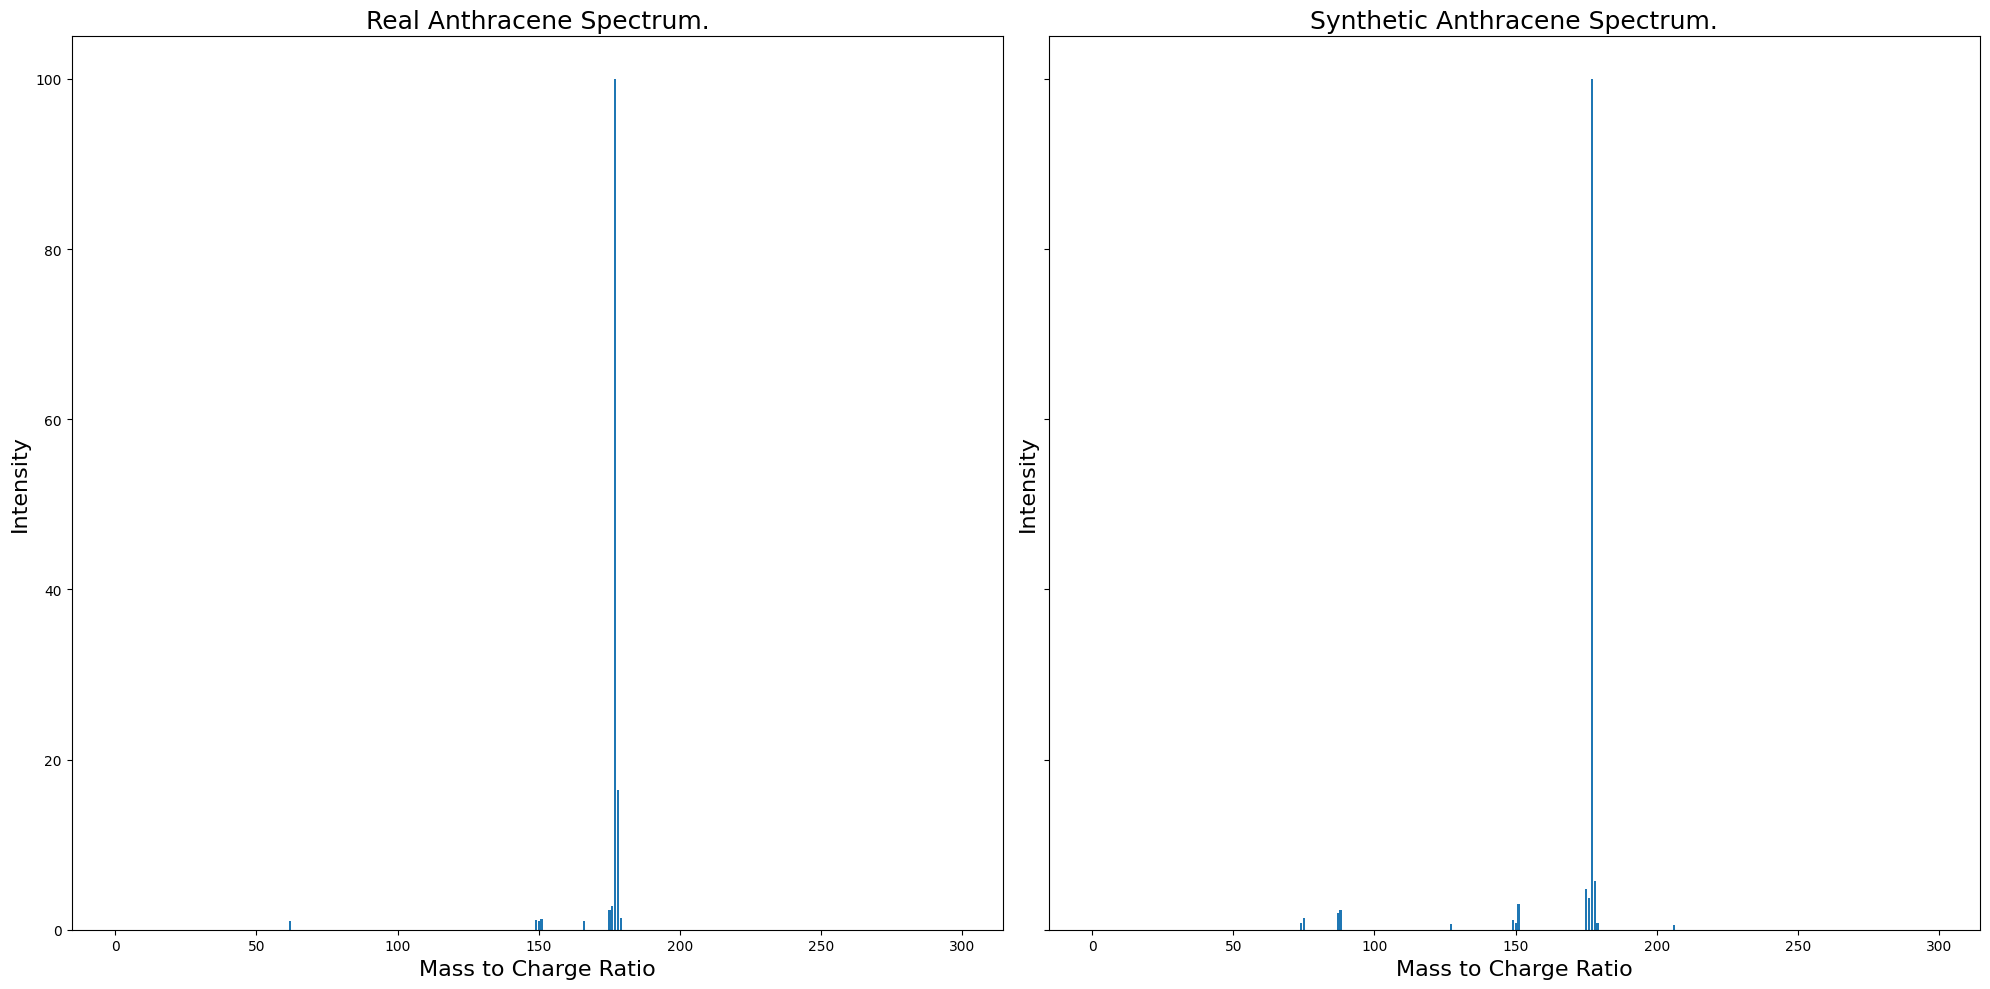

In [148]:
true_spectra = [vec[:915].detach().numpy() for vec in true_values]
output_spectra = [vec[:915].detach().numpy() for vec in model_output]
plot_results(true_spectra, output_spectra, output_labels, idx=[0,2])

In [57]:
# noise_loc = 'spectra'
# train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=noise_loc, noise_pct=1)
# denoiser = Denoiser()
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=200, train_loss_log = [], test_loss_log = [])

In [58]:
# # create x-axis values
# epochs = range(1, len(train_loss_log) + 1)

# # plot train and test loss
# plt.plot(epochs, train_loss_log, 'b', label='Training loss')
# plt.plot(epochs, test_loss_log, 'r', label='Testing loss')
# plt.legend()
# plt.show()

In [59]:
# denoiser.optimizer = torch.optim.AdamW(denoiser.parameters(), lr=.00001)
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=100, train_loss_log=train_loss_log, test_loss_log=test_loss_log)

In [60]:
# output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
# plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

In [61]:
# denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_tmp.pth'
# torch.save(denoiser.state_dict(), denoiser_path)

In [142]:
denoiser.eval()
test_output = []
test_labels = []
test_true_values = []
test_loss = 0

with torch.no_grad(): 
    for batch, true_vals, labels in test_noisy_data:
        output_0= denoiser(batch)
        output_1= denoiser(output_0)
        output_2= denoiser(output_1)

        m_0_loss = denoiser.criterion(output_0, true_vals)
        m_1_loss = denoiser.criterion(output_1, true_vals)
        m_2_loss = denoiser.criterion(output_2, true_vals)

        loss = m_0_loss + m_1_loss + m_2_loss
        test_loss+=loss

    chem_names = [all_chemical_names[list(encoding).index(1)] for encoding in labels]
    for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
        # undo log transformation
        denoised_vector = torch.exp(denoised_vector) - 1
        test_output.append(denoised_vector)
        true_val = torch.exp(true_val) - 1 
        test_true_values.append(true_val)
        test_labels.append(chem_name)

    average_loss = test_loss/len(test_noisy_data)
    print('Loss =', average_loss)

Loss = tensor(0.0629)


Weighted cosine similarity is:  0.99


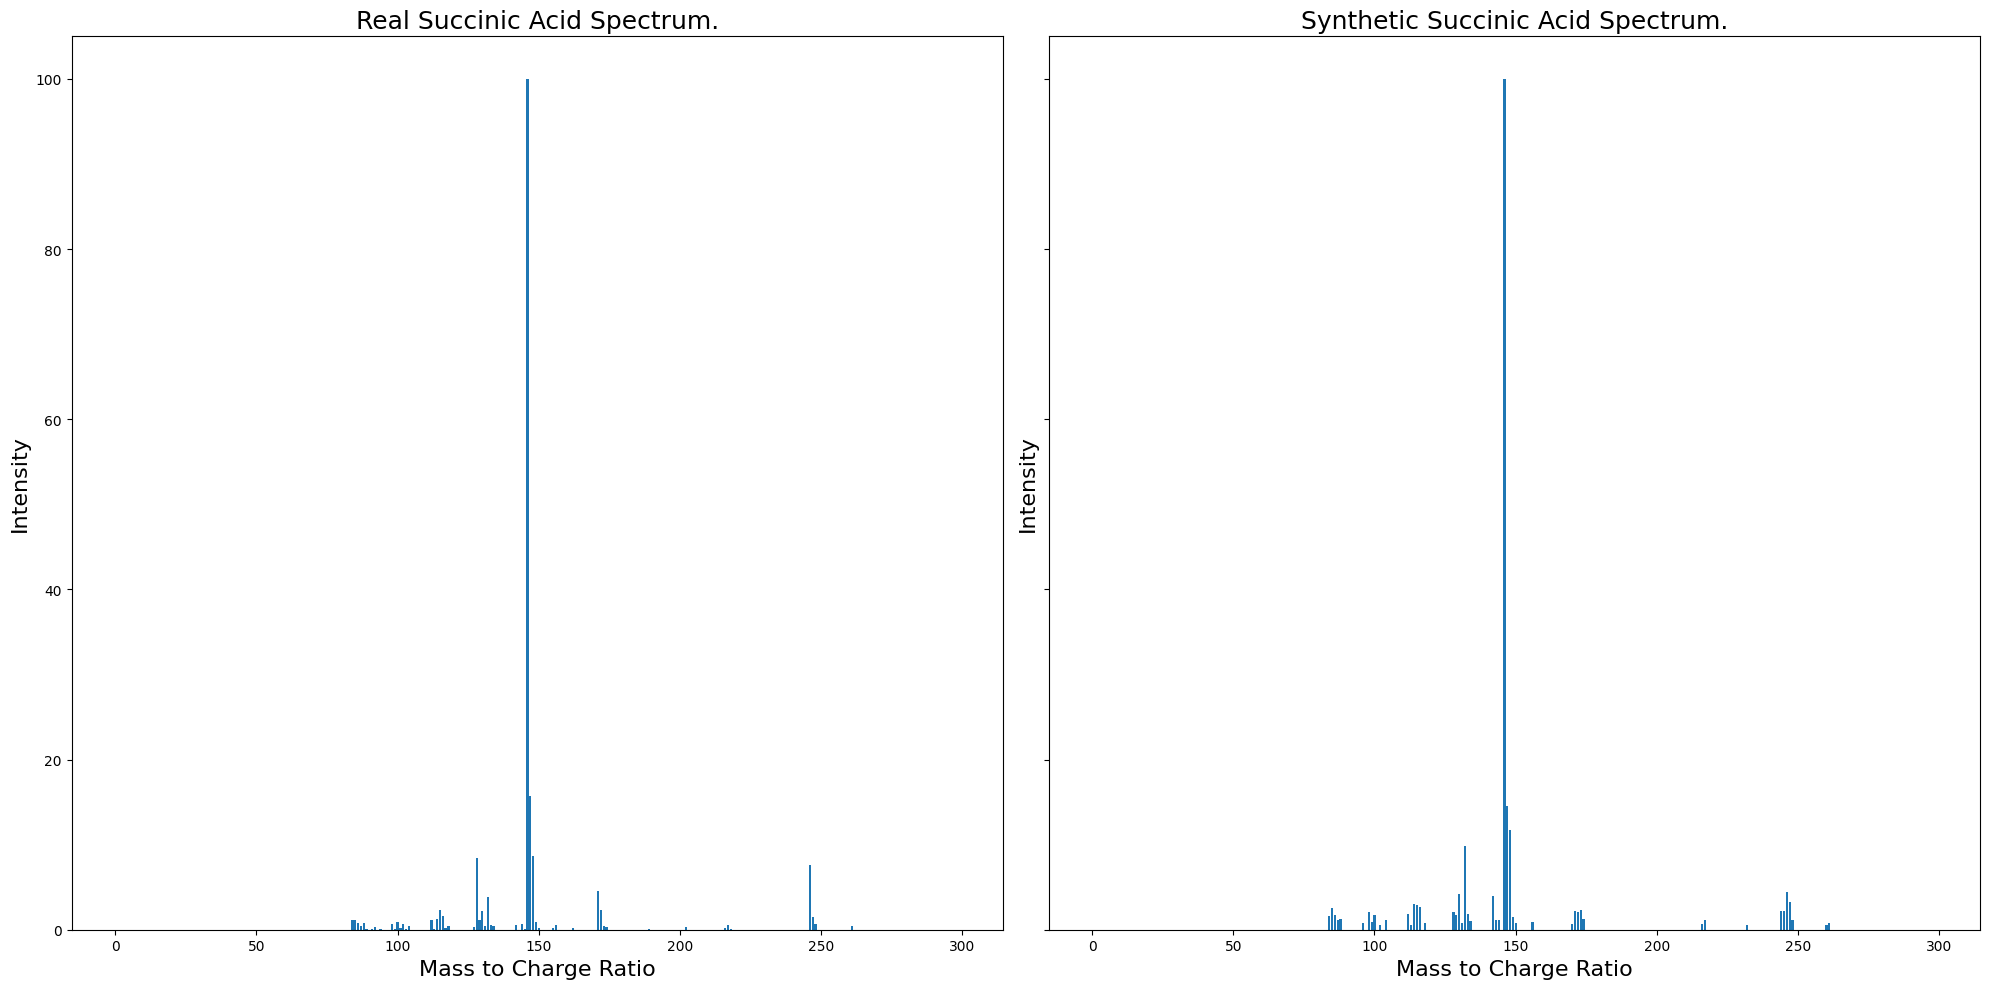

Weighted cosine similarity is:  0.98


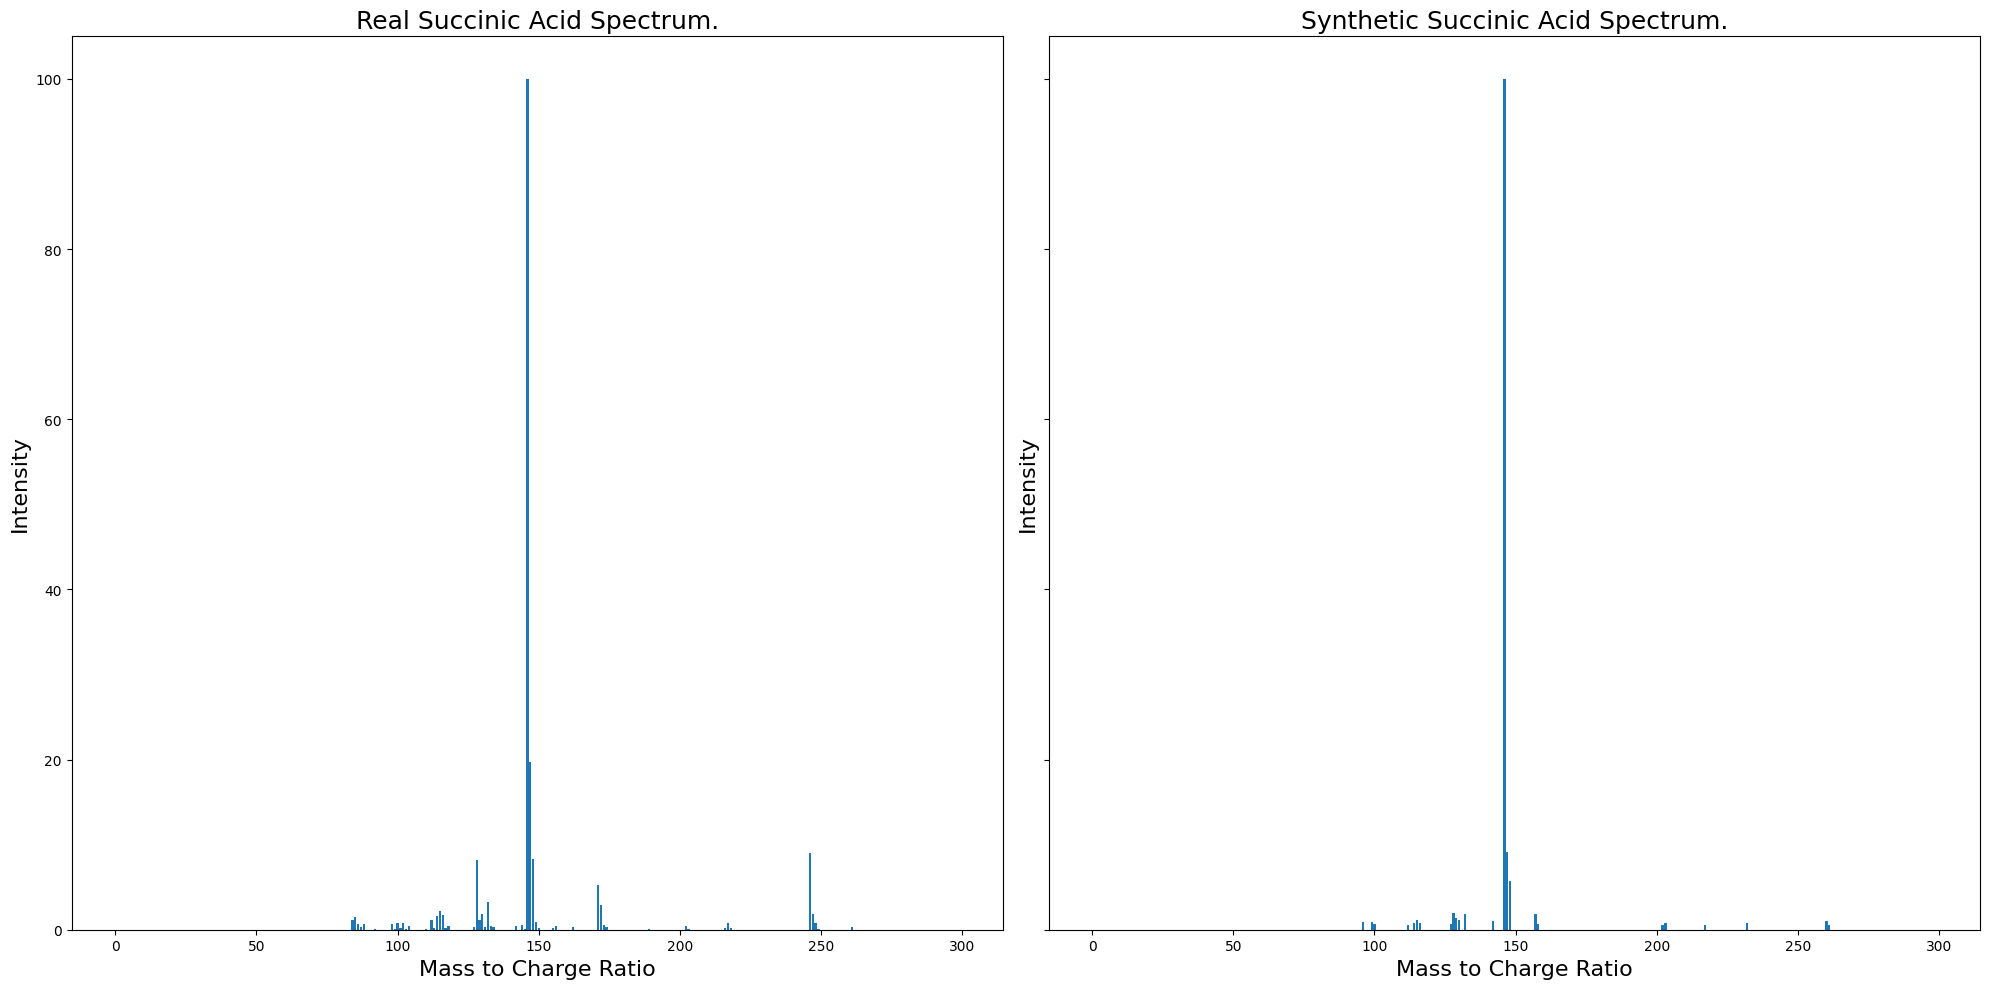

Weighted cosine similarity is:  0.77


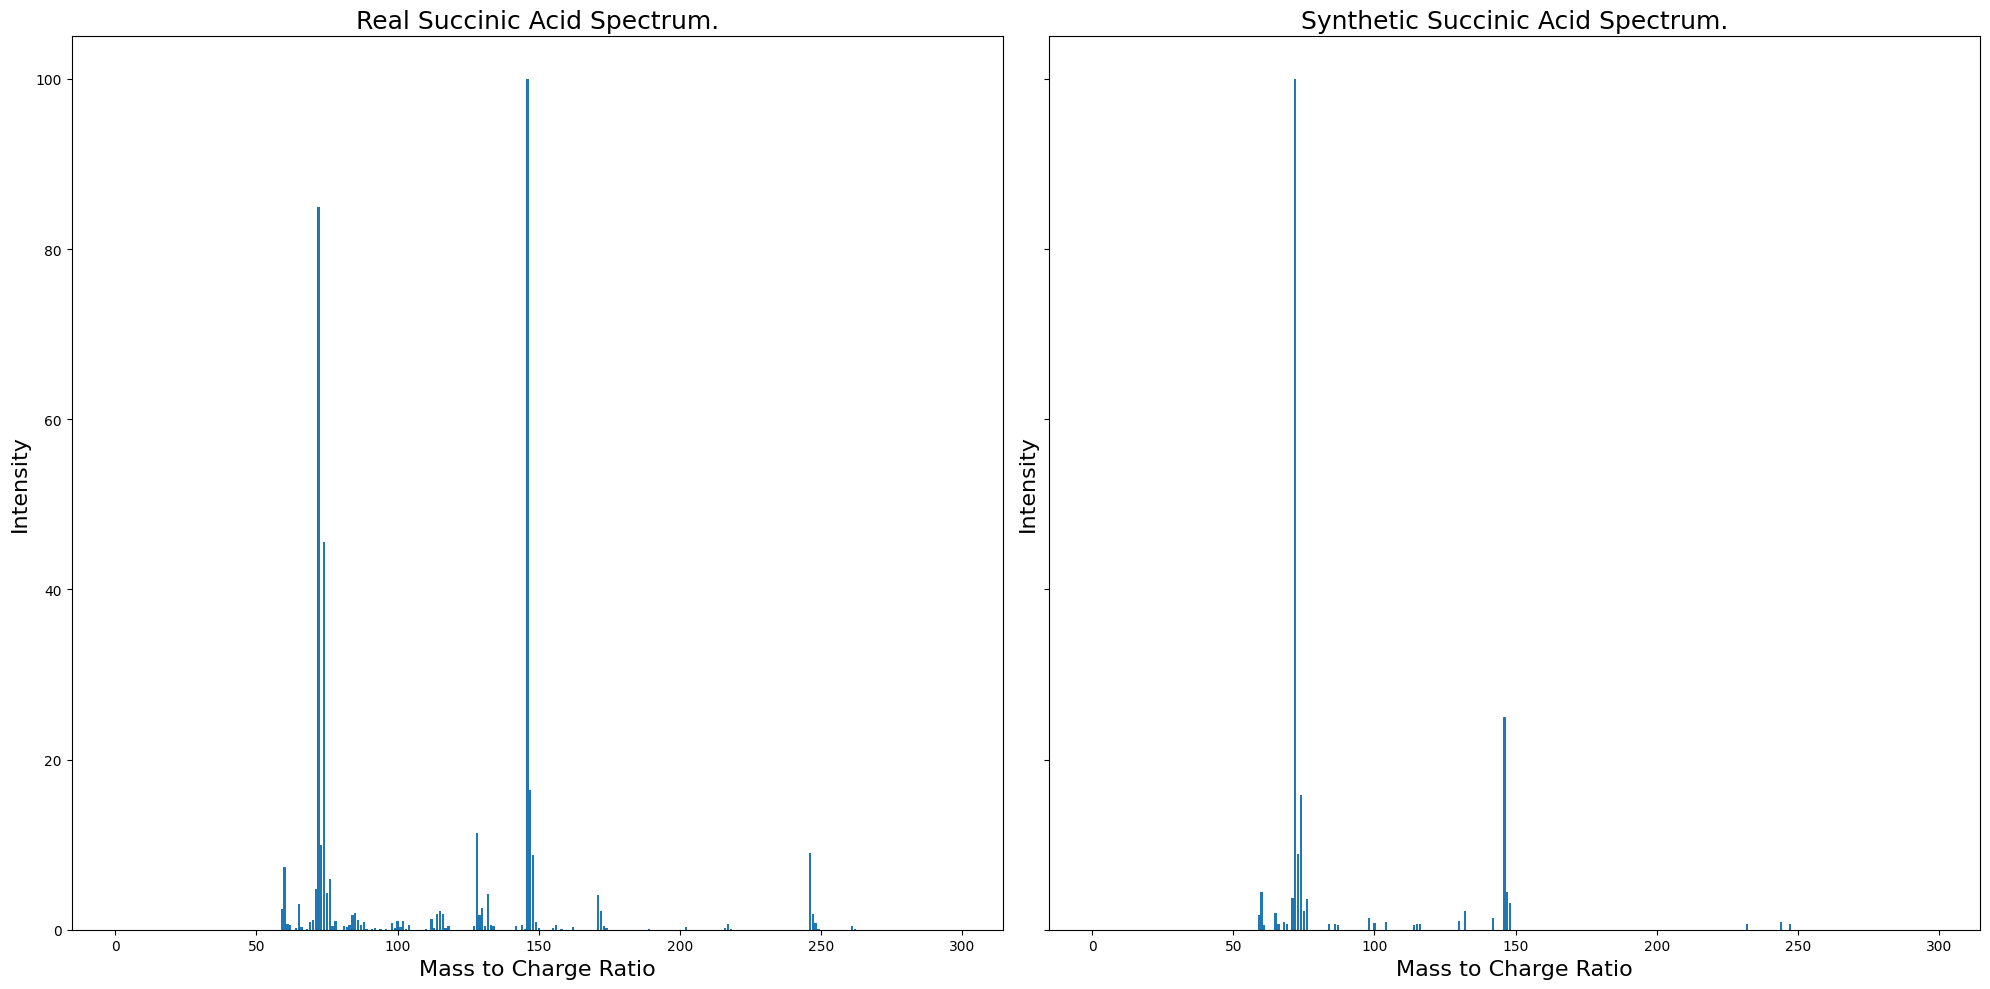

Weighted cosine similarity is:  0.9


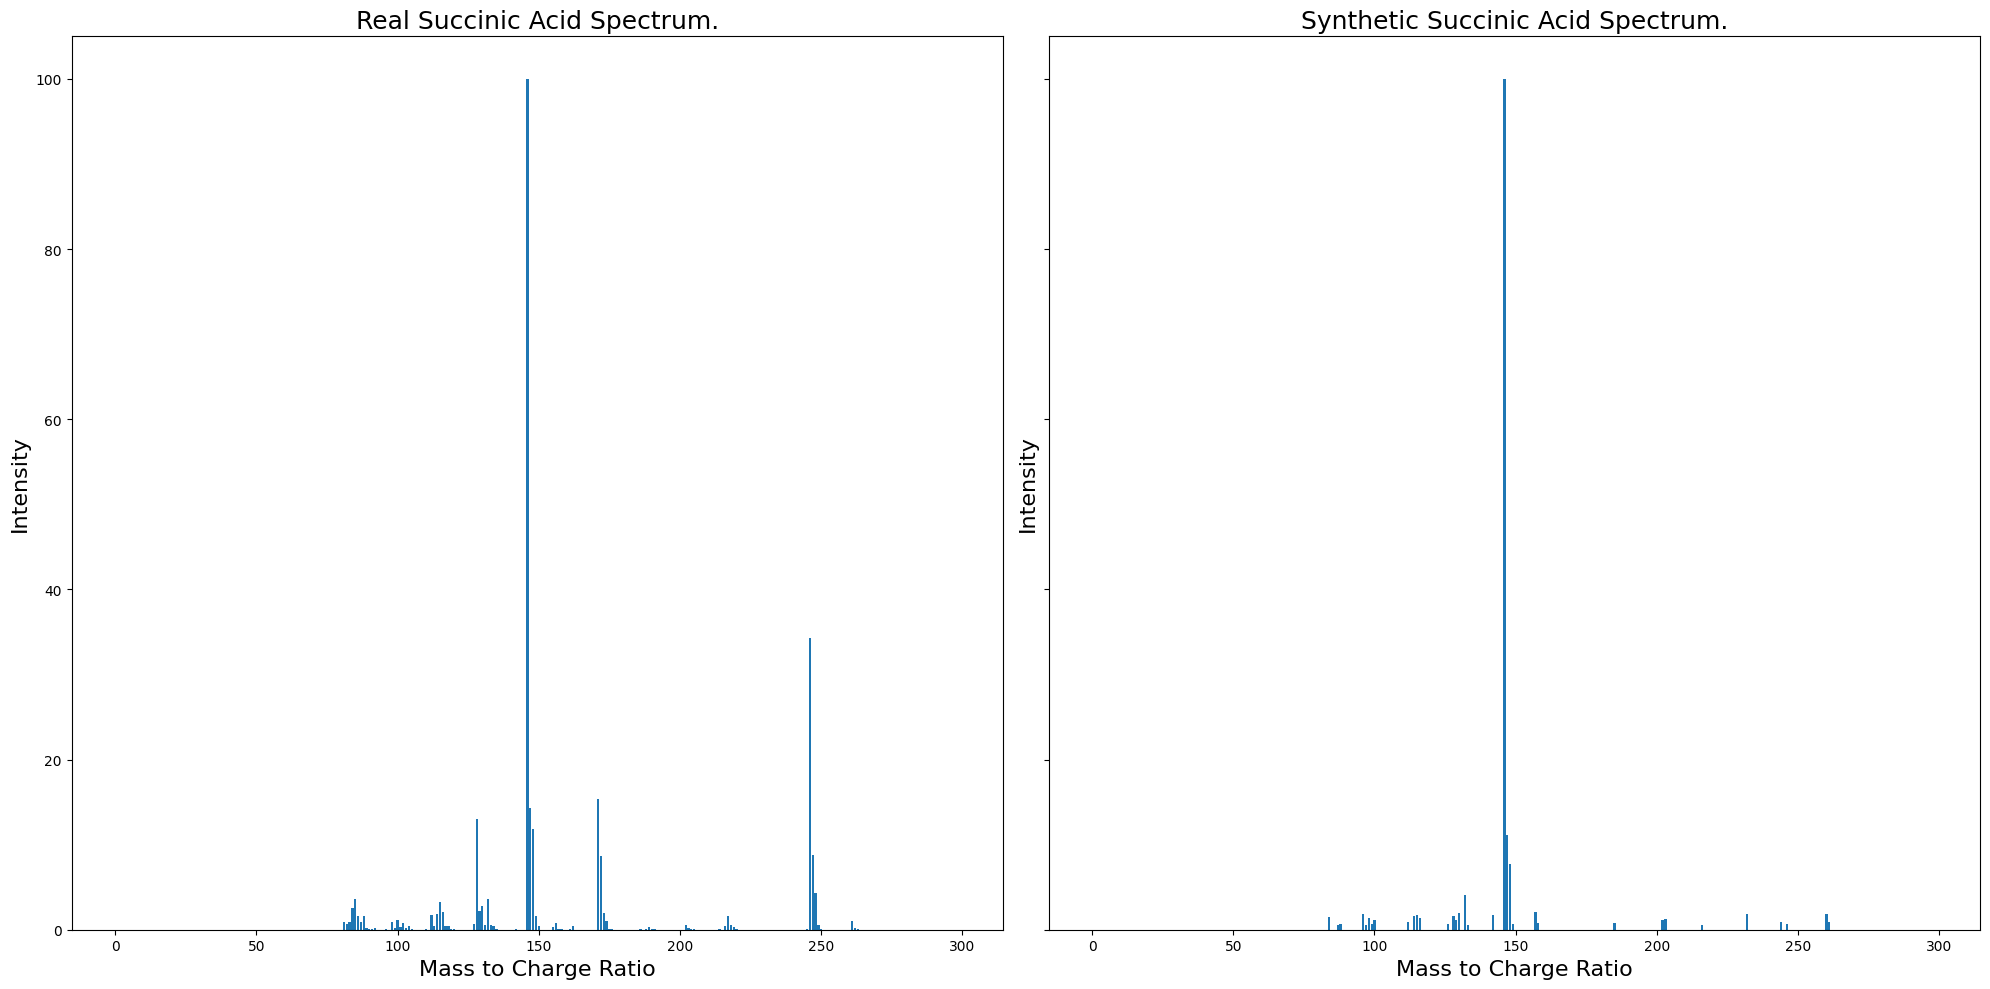

In [145]:
true_spectra = [vec[:300].detach().numpy() for vec in test_true_values]
output_spectra = [vec[:300].detach().numpy() for vec in test_output]
plot_results(true_spectra, output_spectra, test_labels, idx=[0,5])

In [59]:
# test_output_embeddings = [vec[-512:].detach().numpy() for vec in test_output]
# # plot_emb_pca(embeddings, test_output_embeddings, test_labels, train_chems)
# plot_emb_pca(embeddings, test_output_embeddings, test_labels, all_chemical_names)

In [147]:
# get values for test spectra 
# true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
# fake_spec = true_spectra[0]
output_spectra = [vec[:300].detach().numpy() for vec in test_output]
fake_spec = output_spectra[0]
max_val = max(fake_spec)
# print(max_val)
# print(min(fake_spec))
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
# print(min(scaled_spec))
for i, num in enumerate(scaled_spec):
  if num > .5:
    print(i+1, round(float(num), 4))

85 1.5931
86 2.5421
87 1.6793
88 1.1206
89 1.2838
97 0.7858
99 2.0467
100 0.9086
101 1.6797
103 0.5517
105 1.1664
113 1.8618
114 0.5297
115 2.9905
116 2.8601
117 2.6378
119 0.8281
129 2.0923
130 1.7013
131 4.2175
132 0.838
133 9.8188
134 1.8792
135 1.0437
143 3.9541
144 1.0868
145 1.1181
147 100.0
148 14.4867
149 11.767
150 1.5233
151 0.7415
157 0.929
171 0.6283
172 2.1418
173 2.0544
174 2.3202
175 1.2373
217 0.6568
218 1.1242
233 0.5153
245 2.2305
246 2.1532
247 4.4491
248 3.2802
249 1.1673
261 0.5763
262 0.7925


# Generate embeddings and then spectra:
---

In [ ]:
# train_data = []
# true_data = []
# for true_val, pred_val in zip(true_values, model_output):
#     train_data_point = true_val
#     for i in enumerate(train_data_point[927:]):
#         train_data_point[i[0]+927] = pred_val[i[0]+927]
#     train_data.append(train_data_point.detach().clone().numpy())
#     true_data.append(true_val.detach().clone().numpy())
    
# # shifting to make all data positive
# min_value = 1
# input_data = torch.tensor(np.vstack((train_data)).T, dtype=torch.float)
# input_data += min_value
# all_true_vals = torch.tensor(np.vstack((true_data)).T, dtype=torch.float)
# all_true_vals += min_value
# # log transforming data to reduce impact of different scales 
# input_normed = torch.log(input_data)
# trues_normed = torch.log(all_true_vals)
# input_data = TensorDataset(input_normed, trues_normed, output_labels)

# batch_size=32
# # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
# input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)